In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/filtered-varients/annotated.hg38_multianno.vcf
/kaggle/input/filtered-varients/filtered_variants.recode.vcf
/kaggle/input/filtered-varients/filtered_variants_annotated.vcf


## Comprehensive Genomic Variant Analysis: VCF File Processing, Quality Filtering, and Functional Annotation

### Variant Calling and Annotation Analysis

Allele Frequency (AF) Extraction and Statistics:

Purpose: To understand the distribution of allele frequencies in your dataset.
Relevance: Variants with specific allele frequencies can provide insights into the genetic variation within a population. High AF variants are common in the population, whereas low AF variants might be rare or novel mutations.
Filtering Variants with AF Around 0.5:

Purpose: To identify heterozygous variants, which typically have an allele frequency around 0.5.
Relevance: Heterozygous variants can be of particular interest in studies related to genetic diseases, as they can indicate a carrier status for recessive traits or contribute to complex traits.

QUAL Score Analysis:

Purpose: To evaluate the quality of the variant calls.
Relevance: High-quality variants (with high QUAL scores) are more reliable for downstream analyses and interpretations. Low-quality variants might be filtered out to avoid false positives.

# Outline of the Analysis Process:
1. Data Preprocessing:

Load VCF files.
Convert VCF to CSV for easier manipulation.

2. Quality Control:

Extract and analyze QUAL scores.
Filter variants based on quality thresholds.

3. Allele Frequency Analysis:

Extract AF from INFO column.
Calculate statistics for allele frequencies.
Identify variants with specific AF ranges (e.g., around 0.5).

4. Functional Annotation:

Annotate variants with gene names and predicted consequences.
Filter for high-impact variants (e.g., missense, nonsense, frameshift).
Perform pathway analysis or gene set enrichment analysis.

In [2]:
!pip install pandas vcfpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.2/993.2 kB 11.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 63.2 MB/s eta 0:00:00:00:0100:01
  Created wheel for vcfpy: filename=vcfpy-0.13.8-py2.py3-none-any.whl size=34400 sha256=c963f4eedcfe6c6e2a928fab4499e661f402a6346baafdf7b630db81a02fc48e
  Stored in directory: /root/.cache/pip/wheels/f8/18/ae/1270a4895ffbb577ccf51ebe1396ce1dc6ce89f851079a2ec2
Successfully built vcfpy


In [9]:
import pandas as pd
import os

# Function to read VCF file and convert to DataFrame
def read_vcf(file):
    lines = []
    try:
        with open(file, 'r') as f:
            lines = [line.strip() for line in f if not line.startswith('##')]
        if len(lines) == 0:
            raise ValueError("The VCF file is empty or does not contain valid data.")
        header = lines[0].lstrip('#').split('\t')
        records = [line.split('\t') for line in lines[1:]]
        return pd.DataFrame(records, columns=header)
    except Exception as e:
        print(f"Error reading VCF file: {e}")
        if lines:
            print(f"First few lines of the file:\n{lines[:5]}")
        return pd.DataFrame()

# Directory containing VCF files
vcf_directory = '/kaggle/input/filtered-varients'  # Change to your directory containing VCF files

# Convert each VCF file in the directory to CSV
for file in os.listdir(vcf_directory):
    if file.endswith(".vcf"):
        vcf_file_path = os.path.join(vcf_directory, file)
        df = read_vcf(vcf_file_path)
        
        if not df.empty:
            # Save to CSV in /kaggle/working
            csv_file_path = os.path.join('/kaggle/working', os.path.basename(vcf_file_path).replace('.vcf', '.csv'))
            df.to_csv(csv_file_path, index=False)
            print(f"Converted {vcf_file_path} to {csv_file_path}")
        else:
            print(f"Skipped {vcf_file_path} as it is empty or not valid.")

print("Conversion completed.")


Converted /kaggle/input/filtered-varients/annotated.hg38_multianno.vcf to /kaggle/working/annotated.hg38_multianno.csv
Converted /kaggle/input/filtered-varients/filtered_variants.recode.vcf to /kaggle/working/filtered_variants.recode.csv
Error reading VCF file: The VCF file is empty or does not contain valid data.
Skipped /kaggle/input/filtered-varients/filtered_variants_annotated.vcf as it is empty or not valid.
Conversion completed.


In [10]:
!ls -lh /kaggle/working


total 42M
-rw-r--r-- 1 root root  36M Jun 15 07:45 annotated.hg38_multianno.csv
-rw-r--r-- 1 root root 5.6M Jun 15 07:45 filtered_variants.recode.csv


In [12]:
# Read and display the first few rows of the CSV file
import pandas as pd

# Example for annotated.hg38_multianno.csv
df_annotated = pd.read_csv('/kaggle/working/annotated.hg38_multianno.csv')
print("Annotated VCF to CSV:")
print(df_annotated.head())

# Example for filtered_variants.recode.csv
df_filtered = pd.read_csv('/kaggle/working/filtered_variants.recode.csv')
print("Filtered VCF to CSV:")
print(df_filtered.head())



Annotated VCF to CSV:
  CHROM     POS ID REF ALT   QUAL FILTER  \
0     1  918870  .   A   G  77.84      .   
1     1  920719  .   T   G  78.32      .   
2     1  920728  .   A   G  78.32      .   
3     1  931540  .   A   G  85.14      .   
4     1  931558  .   G   A  85.14      .   

                                                INFO          FORMAT  \
0  AC=2;AF=1.00;AN=2;DP=3;ExcessHet=0.0000;FS=0.0...  GT:AD:DP:GQ:PL   
1  AC=2;AF=1.00;AN=2;DP=2;ExcessHet=0.0000;FS=0.0...  GT:AD:DP:GQ:PL   
2  AC=2;AF=1.00;AN=2;DP=2;ExcessHet=0.0000;FS=0.0...  GT:AD:DP:GQ:PL   
3  AC=2;AF=1.00;AN=2;DP=4;ExcessHet=0.0000;FS=0.0...  GT:AD:DP:GQ:PL   
4  AC=2;AF=1.00;AN=2;DP=4;ExcessHet=0.0000;FS=0.0...  GT:AD:DP:GQ:PL   

                sample1  
0    1/1:0,3:3:9:91,9,0  
1    1/1:0,2:2:6:90,6,0  
2    1/1:0,2:2:6:90,6,0  
3  1/1:0,4:4:12:99,12,0  
4  1/1:0,4:4:12:99,12,0  
Filtered VCF to CSV:
  CHROM     POS ID REF ALT   QUAL FILTER INFO          FORMAT  \
0     1  918870  .   A   G  77.84     

/tmp/ipykernel_33/789290006.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_annotated = pd.read_csv('/kaggle/working/annotated.hg38_multianno.csv')
/tmp/ipykernel_33/789290006.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_filtered = pd.read_csv('/kaggle/working/filtered_variants.recode.csv')


In [13]:
#Step 1: Suppress DtypeWarning
# To suppress the DtypeWarning, you can set low_memory=False when reading the CSV files. Here’s how you can do it:
import pandas as pd

# Read the annotated CSV file
df_annotated = pd.read_csv('/kaggle/working/annotated.hg38_multianno.csv', low_memory=False)
print("Annotated VCF to CSV:")
print(df_annotated.head())

# Read the filtered CSV file
df_filtered = pd.read_csv('/kaggle/working/filtered_variants.recode.csv', low_memory=False)
print("Filtered VCF to CSV:")
print(df_filtered.head())


Annotated VCF to CSV:
  CHROM     POS ID REF ALT   QUAL FILTER  \
0     1  918870  .   A   G  77.84      .   
1     1  920719  .   T   G  78.32      .   
2     1  920728  .   A   G  78.32      .   
3     1  931540  .   A   G  85.14      .   
4     1  931558  .   G   A  85.14      .   

                                                INFO          FORMAT  \
0  AC=2;AF=1.00;AN=2;DP=3;ExcessHet=0.0000;FS=0.0...  GT:AD:DP:GQ:PL   
1  AC=2;AF=1.00;AN=2;DP=2;ExcessHet=0.0000;FS=0.0...  GT:AD:DP:GQ:PL   
2  AC=2;AF=1.00;AN=2;DP=2;ExcessHet=0.0000;FS=0.0...  GT:AD:DP:GQ:PL   
3  AC=2;AF=1.00;AN=2;DP=4;ExcessHet=0.0000;FS=0.0...  GT:AD:DP:GQ:PL   
4  AC=2;AF=1.00;AN=2;DP=4;ExcessHet=0.0000;FS=0.0...  GT:AD:DP:GQ:PL   

                sample1  
0    1/1:0,3:3:9:91,9,0  
1    1/1:0,2:2:6:90,6,0  
2    1/1:0,2:2:6:90,6,0  
3  1/1:0,4:4:12:99,12,0  
4  1/1:0,4:4:12:99,12,0  
Filtered VCF to CSV:
  CHROM     POS ID REF ALT   QUAL FILTER INFO          FORMAT  \
0     1  918870  .   A   G  77.84     

In [16]:
df_annotated.shape


(85027, 10)

In [17]:
df_filtered.shape

(85027, 10)

In [19]:
df_annotated.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample1
0,1,918870,.,A,G,77.84,.,AC=2;AF=1.00;AN=2;DP=3;ExcessHet=0.0000;FS=0.0...,GT:AD:DP:GQ:PL,"1/1:0,3:3:9:91,9,0"
1,1,920719,.,T,G,78.32,.,AC=2;AF=1.00;AN=2;DP=2;ExcessHet=0.0000;FS=0.0...,GT:AD:DP:GQ:PL,"1/1:0,2:2:6:90,6,0"
2,1,920728,.,A,G,78.32,.,AC=2;AF=1.00;AN=2;DP=2;ExcessHet=0.0000;FS=0.0...,GT:AD:DP:GQ:PL,"1/1:0,2:2:6:90,6,0"
3,1,931540,.,A,G,85.14,.,AC=2;AF=1.00;AN=2;DP=4;ExcessHet=0.0000;FS=0.0...,GT:AD:DP:GQ:PL,"1/1:0,4:4:12:99,12,0"
4,1,931558,.,G,A,85.14,.,AC=2;AF=1.00;AN=2;DP=4;ExcessHet=0.0000;FS=0.0...,GT:AD:DP:GQ:PL,"1/1:0,4:4:12:99,12,0"


In [18]:
df_filtered.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample1
0,1,918870,.,A,G,77.84,.,.,GT:AD:DP:GQ:PL,"1/1:0,3:3:9:91,9,0"
1,1,920719,.,T,G,78.32,.,.,GT:AD:DP:GQ:PL,"1/1:0,2:2:6:90,6,0"
2,1,920728,.,A,G,78.32,.,.,GT:AD:DP:GQ:PL,"1/1:0,2:2:6:90,6,0"
3,1,931540,.,A,G,85.14,.,.,GT:AD:DP:GQ:PL,"1/1:0,4:4:12:99,12,0"
4,1,931558,.,G,A,85.14,.,.,GT:AD:DP:GQ:PL,"1/1:0,4:4:12:99,12,0"


In [24]:
import pandas as pd

# Read the filtered CSV file
df_filtered = pd.read_csv('/kaggle/working/filtered_variants.recode.csv', low_memory=False)

# Print the first few rows of the entire DataFrame
print("First few rows of the DataFrame:")
print(df_filtered.head(20))  # Adjust the number as needed to see more rows


First few rows of the DataFrame:
   CHROM      POS ID                                                REF ALT  \
0      1   918870  .                                                  A   G   
1      1   920719  .                                                  T   G   
2      1   920728  .                                                  A   G   
3      1   931540  .                                                  A   G   
4      1   931558  .                                                  G   A   
5      1   944296  .                                                  G   A   
6      1   944307  .                                                  T   C   
7      1   975058  .                                                  A   G   
8      1   975093  .                                                  G   A   
9      1   997238  .                                                  C   G   
10     1  1014228  .                                                  G   A   
11     1  1014274  

In [25]:
# Read the annotated CSV file
df_annotated = pd.read_csv('/kaggle/working/annotated.hg38_multianno.csv', low_memory=False)

# Print the first few rows of the entire DataFrame
print("First few rows of the annotated DataFrame:")
print(df_annotated.head(20))  # Adjust the number as needed to see more rows


First few rows of the annotated DataFrame:
   CHROM      POS ID                                                REF ALT  \
0      1   918870  .                                                  A   G   
1      1   920719  .                                                  T   G   
2      1   920728  .                                                  A   G   
3      1   931540  .                                                  A   G   
4      1   931558  .                                                  G   A   
5      1   944296  .                                                  G   A   
6      1   944307  .                                                  T   C   
7      1   975058  .                                                  A   G   
8      1   975093  .                                                  G   A   
9      1   997238  .                                                  C   G   
10     1  1014228  .                                                  G   A   
11     1 

Basic statistics for AF:
count    85027.000000
mean         0.930246
std          0.173239
min          0.500000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: AF, dtype: float64
Number of variants with AF around 0.5: 11862


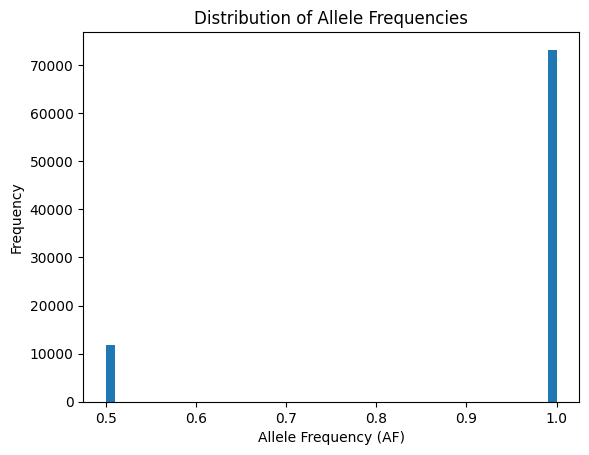

Basic statistics for QUAL:
count    85027.000000
mean       301.679986
std        967.394210
min         30.010000
25%         45.320000
50%         78.320000
75%        210.960000
max      36310.060000
Name: QUAL, dtype: float64
Number of high-quality variants: 85027


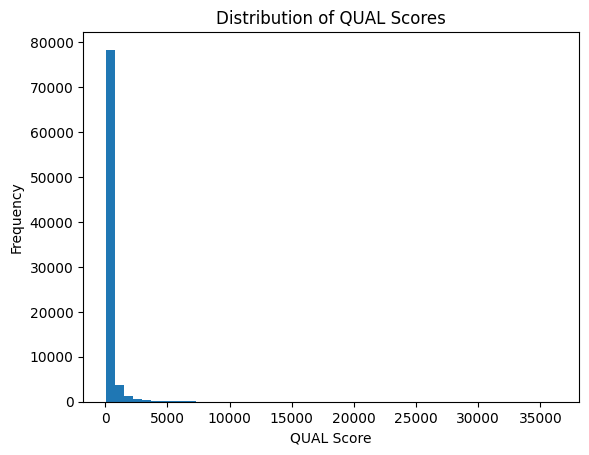

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the annotated CSV file
df_annotated = pd.read_csv('/kaggle/working/annotated.hg38_multianno.csv', low_memory=False)

# Extract AF values from INFO column
df_annotated['AF'] = df_annotated['INFO'].str.extract(r'AF=([0-9\.]+)').astype(float)

# Calculate basic statistics for AF
print("Basic statistics for AF:")
print(df_annotated['AF'].describe())

# Filter variants with AF around 0.5
variants_af_around_0_5 = df_annotated[(df_annotated['AF'] >= 0.45) & (df_annotated['AF'] <= 0.55)]
print(f"Number of variants with AF around 0.5: {len(variants_af_around_0_5)}")

# Plot the distribution of AF
plt.hist(df_annotated['AF'].dropna(), bins=50)
plt.title('Distribution of Allele Frequencies')
plt.xlabel('Allele Frequency (AF)')
plt.ylabel('Frequency')
plt.show()

# Calculate basic statistics for QUAL
print("Basic statistics for QUAL:")
print(df_annotated['QUAL'].describe())

# Filter high-quality variants
high_quality_variants = df_annotated[df_annotated['QUAL'].astype(float) > 30]
print(f"Number of high-quality variants: {len(high_quality_variants)}")

# Plot the distribution of QUAL scores
plt.hist(df_annotated['QUAL'].astype(float), bins=50)
plt.title('Distribution of QUAL Scores')
plt.xlabel('QUAL Score')
plt.ylabel('Frequency')
plt.show()


## Functional Annotation

In [ ]:
!pip install pandas requests


## Genotype-Phenotype Correlation
Genotype-phenotype correlation involves examining the relationship between genetic variants (genotype) and observable traits (phenotype). perform genotype-phenotype correlation using annotated variant data in Python.

Steps
1. Prepare Phenotype Data: Ensure you have a corresponding phenotype dataset.

2. Merge Genotype and Phenotype Data: Combine the genotype data with phenotype information.

3. Statistical Analysis: Perform statistical tests to identify significant correlations between genotypes and phenotypes